In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.metrics import r2_score, root_mean_squared_error

import shap
from pathlib import Path

# Project root = folder where the notebook is located
ROOT = Path().resolve()

print("Project root:", ROOT)



Project root: C:\Users\Aman\WiDS-25\Week-2


In [38]:
# Load dataset
data_path = ROOT / "DATASET.xlsx"

df = pd.read_excel(data_path)

print(df.shape)
df.head()

(50411, 79)


,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1750,AFG,2802560.0,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1753,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1754,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Ensure correct dtypes
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Drop rows with missing target
df = df.dropna(subset=["co2"])

# Sort explicitly by time
df = df.sort_values("year").reset_index(drop=True)

print(df["year"].min(), df["year"].max())


1750 2024


In [42]:
leaky_columns = [
    # direct CO2 variants
     "co2_per_gdp", "co2_per_unit_energy",
    "co2_including_luc", "co2_including_luc_per_capita",
    "co2_including_luc_per_gdp",
    
    # growth & shares
    "co2_growth_abs", "co2_growth_prct",
    "share_global_co2", "share_global_co2_including_luc",
    
    # cumulative values
    "cumulative_co2", "cumulative_co2_including_luc",
    
    # downstream climate effects
    "temperature_change_from_co2",
    "temperature_change_from_ghg",
]

df = df.drop(columns=[c for c in leaky_columns if c in df.columns])


In [45]:


target = "co2"

feature_cols = [
    "gdp",
    "primary_energy_consumption",
    "energy_per_capita",
    "energy_per_gdp",
    "coal_co2",
    "oil_co2",
    "gas_co2",
    "cement_co2",
    "trade_co2",
    "year",
    "country"
]

feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols]
y = df[target]


In [46]:
# Determine split year using only available CO2 data
unique_years = np.sort(X["year"].unique())
split_index = int(0.8 * len(unique_years))
split_year = unique_years[split_index]

print("Train up to year:", split_year)

train_idx = X["year"] <= split_year
test_idx  = X["year"] > split_year

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Drop features that are all-NaN in training data
dead_features = [
    col for col in X_train.columns
    if X_train[col].isna().all()
]

print("Dropping features with no historical data:", dead_features)

X_train = X_train.drop(columns=dead_features)
X_test  = X_test.drop(columns=dead_features)



Train up to year: 1970
Dropping features with no historical data: ['trade_co2']


In [47]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = ["country"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)



In [48]:
lr_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", Ridge(alpha=1.0))
    ]
)

lr_model.fit(X_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [49]:
rf_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

rf_model.fit(X_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [50]:
xgb_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", XGBRegressor(
            n_estimators=500,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42
        ))
    ]
)

xgb_model.fit(X_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [51]:
def evaluate(model, X_test, y_test, name):
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} | RMSE: {rmse:.2f}, R2: {r2:.3f}")
    return preds

def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             linestyle="--")
    plt.xlabel("Actual CO₂ emissions")
    plt.ylabel("Predicted CO₂ emissions")
    plt.title(title)
    plt.tight_layout()
    plt.show()



Linear | RMSE: 1377.06, R2: 0.761
Random Forest | RMSE: 1539.27, R2: 0.702
XGBoost | RMSE: 1436.77, R2: 0.740


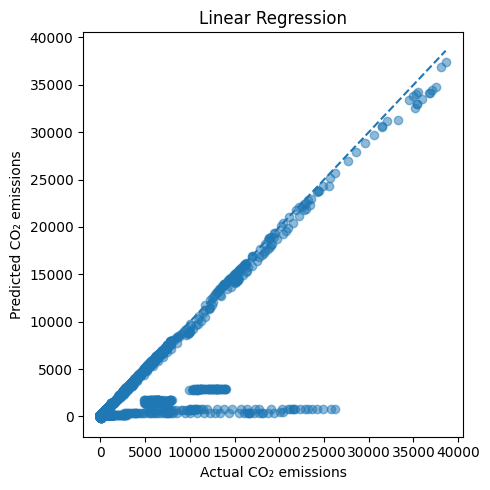

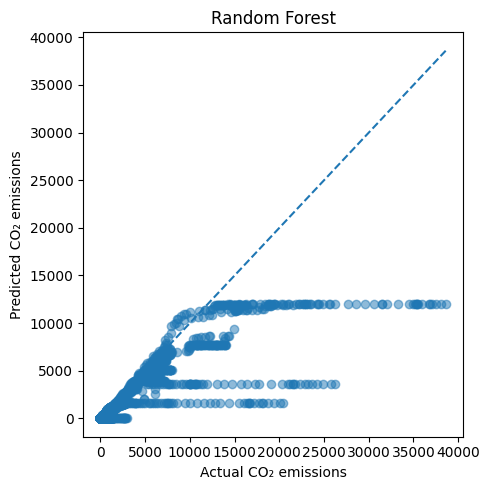

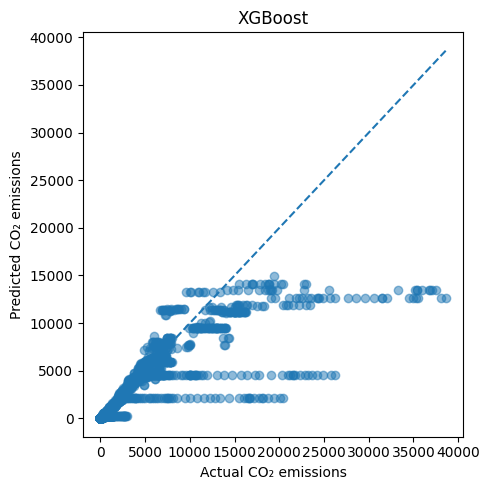

In [52]:
pred_lr  = evaluate(lr_model,  X_test, y_test, "Linear")
pred_rf  = evaluate(rf_model,  X_test, y_test, "Random Forest")
pred_xgb = evaluate(xgb_model, X_test, y_test, "XGBoost")

plot_pred_vs_actual(y_test, pred_lr,  "Linear Regression")
plot_pred_vs_actual(y_test, pred_rf,  "Random Forest")
plot_pred_vs_actual(y_test, pred_xgb, "XGBoost")



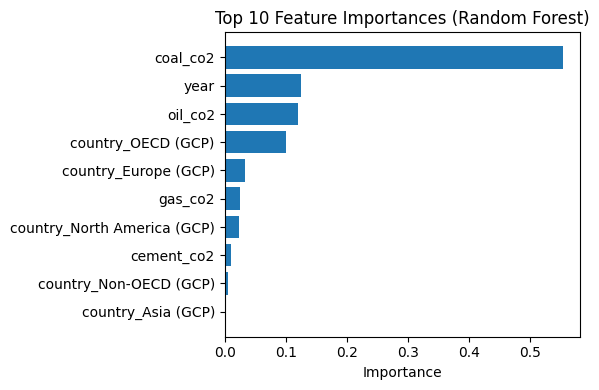

In [54]:
rf = rf_model.named_steps["model"]
importances = rf.feature_importances_

prep = rf_model.named_steps["prep"]

# numeric feature names (unchanged)
num_features = prep.transformers_[0][2]

# expanded categorical feature names (one-hot)
cat_encoder = prep.transformers_[1][1]
cat_features = cat_encoder.get_feature_names_out(categorical_features)

feature_names = list(num_features) + list(cat_features)

assert len(feature_names) == len(importances)

imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)

imp_df.head(10)

topk = 10

plt.figure(figsize=(6,4))
plt.barh(
    imp_df.head(topk)["feature"][::-1],
    imp_df.head(topk)["importance"][::-1]
)
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


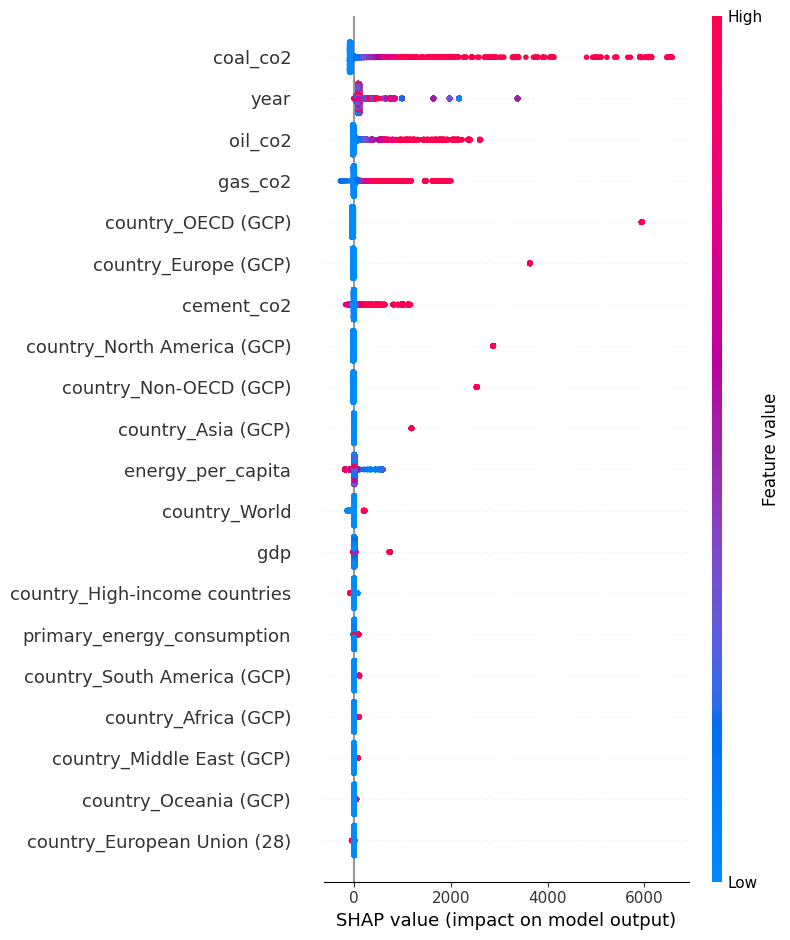

In [55]:
X_test_transformed = xgb_model.named_steps["prep"].transform(X_test)
xgb_inner = xgb_model.named_steps["model"]

explainer = shap.Explainer(xgb_inner)
shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, feature_names=feature_names)
